<a href="https://colab.research.google.com/github/repro-school/training-fens/blob/main/0-GLM_examp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome

![GLM](https://www.brainvoyager.com/bv/doc/UsersGuide/StatisticalAnalysis/Images/GLM_fig1.png)

In this demonstration, we will be fitting a simple GLM to some fMRI data.

Here is what we will be doing:



1. We will load in some fMRI data that was collected during movie-watching. We will also download and view the movie that the participants watched.
2. We will then perform a very simple GLM. 
3. We will then apply these principles from the simple GLM and use this to model the fMRI data






## Ok, but, where am ⁉

You are currently using [a google colab notebook](https://research.google.com/colaboratory/faq.html). This is a platform that allows us to run python code using only a web-browser. This is a very useful platform for several reasons.

1. First, it allows us to all use a consistent system - which avoids us having to go through the pain of installing and configuring python for our own specific computers.

2. Furthermore, this allows us to use the power of googles computing resources, rather than our own.  

3. We can share these google colab notebooks in a similar way to which we share other google documents and store them in our drive. 

You can learn a little bit about google colab by watching this video by the wonderful Jake Vanderplas. Just hover over the cell below and press the play button to reveal a video.

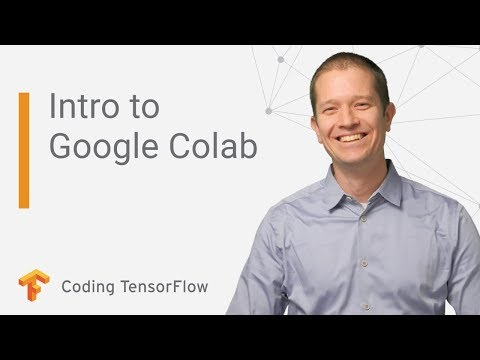

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('inN8seMm7UI')

## Today's playlist 🎧

I made a playlist for us on spotify. Running the below cell will allow you to play a sample of this. If you like the sound of it, you can then follow the link to acess the full playlist (this is not an essential part of this tutorial 😀).

In [ ]:
from IPython.core.display import HTML
HTML('<iframe style="border-radius:12px" src="https://open.spotify.com/embed/playlist/1TyzaWSpkUjX4HzSicIi6a?utm_source=generator" width="100%" height="380" frameBorder="0" allowfullscreen="" allow="autoplay; clipboard-write; encrypted-media; fullscreen; picture-in-picture" loading="lazy"></iframe>')

/usr/local/lib/python3.8/dist-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


# Setup

## Ok, how do I get started?

First, we need to make a few preparations. Let's start by installing a few packages that we need. **This will take a few minutes** - and it will produce some output, which you can ignore.

The code that drives all of this is a little involved, so I have hidden this for now. 

All you need to press is the play button to the lower-left. When it has finished you will see a green tick, as shown below. A message also will be printed to say "Everything all set up!". When you see this, you can continue.

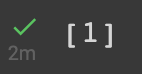

In [ ]:
#@title ↓ --- Run this cell by pressing the play button below
# this cell installs some dependencies. 
# feel free to disregard the output this generates

!apt -qq install inkscape &> /dev/null
!pip -qq install nibabel nilearn &> /dev/null
!pip -qq install git+https://github.com/gallantlab/pycortex.git#egg=pycortex &> /dev/null
! pip install opencv-python &> /dev/null
! pip install googledrivedownloader &> /dev/null
! pip install pytube &> /dev/null


import numpy as np
import scipy as sp
import nibabel as nb
import nilearn as nl
from nilearn.surface import load_surf_data
import os, shutil, urllib.request

from matplotlib import rc
from matplotlib import cm
import matplotlib as mpl
rc('animation', html='jshtml')

import matplotlib.pyplot as plt
%matplotlib inline 

import pickle

from platform import python_version
pversion='.'.join(python_version().split('.') [:-1])

#
# this cell ensures that we can work with our own surface from within the colab environment
#
wrong_filestore_location='/usr/share/pycortex/db'

os.makedirs('/content/pycortex/db', exist_ok=True)
os.makedirs('/content/pycortex/colormaps', exist_ok=True)
os.makedirs('/content/data', exist_ok=True)

with open('/usr/local/lib/python{pversion}/dist-packages/cortex/defaults.cfg'.format(pversion=pversion), 'r') as f:
  file_source = f.read()

replace_string = file_source.replace(wrong_filestore_location, '/content/pycortex/db') #save output 
with open('/usr/local/lib/python{pversion}/dist-packages/cortex/defaults.cfg'.format(pversion=pversion), 'w') as f:
  f.write(replace_string)   

os.chdir('/tmp/')
!git clone https://github.com/gallantlab/pycortex.git
!cp /tmp/pycortex/filestore/colormaps/* /content/pycortex/colormaps/

#
# and we'll download our average hcp subject for pycortex visualization
#

pycortex_sj_URL = "https://ndownloader.figshare.com/files/25768841"

urllib.request.urlretrieve(pycortex_sj_URL, os.path.join('/content/pycortex/db', 'hcp_999999.zip'))
!unzip -qq /content/pycortex/db/hcp_999999.zip -d /content/pycortex/db/


import cv2
import numpy as np
import matplotlib.pyplot as plt
class videohandler(object):

    def __init__(self,inputpath='/content/data/movie.mp4'):
        """Function to extract frames from input video file
        and save them as separate frames in an output directory.
        Args:
        input_loc: Input video file.
        output_loc: Output directory to save the frames.
        Returns:
        None
        """        
        self.input_loc=inputpath
                
        self.cap = cv2.VideoCapture(self.input_loc)
        # Find the number of frames
        self.video_length = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    
        self.fps=self.cap.get(cv2.CAP_PROP_FPS)
        print(self.fps)
        
        self.duration_secs=self.video_length/self.fps

        self.secs=np.linspace(0,round(self.duration_secs),self.video_length)
                
    
 
    
    def get_video_section(self,start,end,sf=4,ds=6):
        self.cap = cv2.VideoCapture(self.input_loc)
        myfilt=np.where(np.logical_and(self.secs>start,self.secs<end))[0]
        myfilt=myfilt[0::ds]
        
        frames=[]
        for ind in myfilt:
            self.cap.set(cv2.CAP_PROP_POS_FRAMES,ind)
            ret, frame = self.cap.read()
            
            frames.append(cv2.resize(frame,dsize=(int(frame.shape[1]/sf),int(frame.shape[0]/sf))))
        
        self.cap.release()
        self.cap = 0
        cv2.destroyAllWindows()
        return frames
    
    
    def show_images(self,images, cols = 1, titles = None):

        assert((titles is None)or (len(images) == len(titles)))
        n_images = len(images)
        if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
        fig = plt.figure()
        for n, (image, title) in enumerate(zip(images, titles)):
            a = fig.add_subplot(cols, int(np.ceil(n_images/float(cols))), n + 1)
            if image.ndim == 2:
                plt.gray()
            plt.imshow(image)
            a.set_title(title)
            a.axis("off")
        fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
        plt.show()
    
    def show_video_section(self,start,end,ncols=5):
        
        imlist=self.get_video_section(start,end)
        self.show_images(imlist,cols=ncols)


print('Everything all set up!')

Cloning into 'pycortex'...
remote: Enumerating objects: 24562, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 24562 (delta 90), reused 146 (delta 79), pack-reused 24385
Receiving objects: 100% (24562/24562), 476.76 MiB | 36.09 MiB/s, done.
Resolving deltas: 100% (18922/18922), done.
Everything all set up!


# About the data

We will be analysing data from the [human connectome project](https://www.humanconnectome.org/study/hcp-young-adult) (HCP) movie-watching dataset.


Essentially, in this experiment, nearly 200 participants sat in an MRI scanner for an hour while they watched various movie clips that lasted a few minutes each. 📺

It's as simple as that. There were no independent variables manipulated, or task instructions given to the participant. *Simple*

## What about pre-processing?
The data we will be using has already been pre-processed, so we don't need to worry about that side of things.

We will also be analysing data from just one subject taken from just a brief section of the movie (the participants viewed ~ 1 hour of movies, but we will be analysing just a 3 minute segment).

Hence, this is just 3 mins of data from 1 participant

## Download the stimulus

First, to give us some sense of what the participant was watching during the experiment, let's download the movie the participant viewed.

In [ ]:
from pytube import YouTube
import os
import cortex

def downloadYouTube(videourl, path):

    yt = YouTube(videourl)
    yt = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first()
    if not os.path.exists(path):
        os.makedirs(path)
    yt.download(path)

os.makedirs('./content/data/',exist_ok=True)

downloadYouTube('https://youtu.be/eymjnLD0mLc', '/content/data/movie')

Take a moment to view this movie so you can get a sense of what the participants were presented with.

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('eymjnLD0mLc')

You will notice that the content of the movie is quite varied, it contains lots of people, lots of outdoor scenes, and text appears on the screen at various points. Later on we will be recording the onsets and offsets of these different types of stimuli to make a design matrix for our modeling.

## Download the data.

Now let's download the functional data that was collected while the participant watched the movie.

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1BjEhAPnWwLUrMqJ4riaoHEVg4bBEV2Kd',
                                    dest_path='/content/data/movie_data.npy',
                                    unzip=True)
ts_data=np.load('/content/data/movie_data.npy')

Lets have a look at the shape of the data.

In [ ]:
ts_data.shape

It is a matrix with 118584 rows and 205 columns. What could this mean?

First of all, one thing that may appear a little strange to you is that this dataset is 2 dimensional, not 4 dimensional.

Usually, we expect the format of the functional data to be 4 dimensional -  thats 3 dimensions of the image (X, Y, Z) and time.

However, this data is 2D. This is because the data is in 'surface' space, rather than the 'volumetric' space we are used to. You can read a little about this distnction [here](https://andysbrainbook.readthedocs.io/en/latest/FreeSurfer/FS_ShortCourse/FS_01_BasicTerms.html).

Don't worry about this too much, but essentially the first dimension (118584) indicates that we have recorded from 118584 positions in the brain. You can therefore think of this first value as reflecting the 'voxel number'.

We also note that the second dimension is *205*. This is the number of timepoints in the dataset.

You'll also notice that this corresponds to the number of seconds in the movie clip you just watched (3 mins 25 seconds is 205 seconds). Thus, for each voxel, we have one datapoint for every second of the movie. 

Hence, we can reason that the *TR* of this experiment is 1 second.

Let's plot some data from a random voxel. 

In [ ]:
import matplotlib.pyplot as plt
plt.plot(ts_data[147,:])
plt.xlabel('time (TR)')
plt.ylabel('BOLD Response (Y)')

Since our data are in surface space, we can also plot our data onto a nice flat representation of the brain. Let's plot the mean of the responses over time.

In [ ]:
mean_data=np.mean(ts_data,axis=1)
data_to_plot=cortex.Vertex(mean_data,vmin=np.nanmin(mean_data),vmax=np.nanmax(mean_data),subject='hcp_999999')
flatmap=cortex.quickshow(data_to_plot)

Here we see the mean data plotted onto a flattened representation of the brain. We see larger responses (red values) towards the primary visual cortex (V1) and the primary auditory cortex (A1).

This makes sense, since this participant watched an audiovisual movie, meaning that their visual and auditory cortices were most stimulated.

# Take a break 1.

Ok, lets take a break and discuss what we have done so far.

![stop sign](https://upload.wikimedia.org/wikipedia/commons/8/81/Stop_sign.png)

# The GLM

Ok, lets go back a stage. Before we run a more complex GLM on our huge brain data, let's first run a very simple GLM on a small amount of data. 


# So, what is the GLM?

A GLM os a method to model the relation between some predictor variables $X$ and a
variable we want to explain $y$ (which in our case is the fMRI data throughout the brain). Specifically, linear
regression uses a vector of weights $\beta$ to
predict the output

\begin{align}\hat{y} = X\beta\end{align}

Hence, the predictions of our model $\hat{y}$ are the weighted sum of each of the regressors in $X$ with each of our weights in $\beta$ 


The model is considered accurate if the predictions $\hat{y}$ are close
to the true output values $y$. Therefore, a good linear regression model
minimizes the sum of squared errors:

\begin{align}\beta\ = \arg\min_\beta\ ||X\beta\ - y||^2\end{align}

This is the simplest model for linear regression, and it is known as *ordinary
least squares* (OLS).

## A simple GLM.
Lets do a very simple regression now.



### Defining X and Y.

Let's set up a predictor variable (X) and a variable that we want to explain (Y).

These are just random numbers that I made up.

In [ ]:
import numpy as np
X = np.array([5,7,8,7,2,17,2,9,4,11,12,9,6])

Y = np.array([99,86,87,88,111,86,103,87,94,78,77,85,86])

In [ ]:
import matplotlib.pyplot as plt
plt.plot(X,Y,'*')

Our goal is to explain Y as X multiplied by some value (${\beta}$) that we estimate via a GLM.

As you probably were told in your previous statistics classes, you should always “model the intercept” when running any (regression) model. The parameter corresponding to the intercept refers to the average value of your  Y when all predictors in  are 0. So, conceptually, the intercept models the mean when of Y when controlling for our (other) predictors.

To “model the intercept”, you should add an extra “constant predictor” to your design matrix (X). This “constant predictor” means simply a column with a constant value, usually all ones. (You’ll figure out why you should do this later in the tutorial.)

Therefore, lets add a column of ones to our design matrix.

In [ ]:
 X = np.array([[5,7,8,7,2,17,2,9,4,11,12,9,6],
              [1,1,1,1,1,1,1,1,1,1,1,1,1]]).T

We can now plot our design matrix as a matrix of two columns, one with the predictor variable itself, one with a constant value (1) which is used to model the intercept.

In [ ]:
plt.matshow(X)

### Fitting the model

Now as for estimation, the $\beta\$s leading to the minimum squared error can be found
analytically with the formula:

\begin{align}\beta\ = (X^\top X)^{-1}  X^\top y\end{align}


In [ ]:
beta = np.linalg.solve(X.T @ X, X.T @ Y)

In [ ]:
beta

we can see that our slope is -1.75 and that our intercept is 103.1059

### Generating predictions

Recall that our linear regression formula states that to generate out prediction (yhat) we need to multiply our design matrix by our betas

\begin{align}\hat{y} = X\beta\end{align}

In this case, we have two columns in X and one beta for each, so in full this is:

\begin{align}\hat{y}= X(1)\beta(1) + X(2)\beta(2) \end{align}

Thus, we get our linear prediction ${\hat{y}}$ as follows. We

1. Multiply each column in our design matrix by its estimated beta weight and 
2. Sum these to get our predictions.

Let's do this now

In [ ]:
# Multiply each column in X by its corresponding beta weight.
yhat=(X[:,0]*beta[0])+(X[:,1]*beta[1])

Let's now plot this prediction that we get,

In [ ]:
plt.plot(X[:,0],yhat,label='Prediction')
plt.plot(X[:,0],Y,'*',label='Data')
plt.legend()

One thing worth highligting is that what we are doing here to generate the predictions:

\begin{align}\hat{y} = X\beta\end{align}

is a form of matrix multiplication, multiplying each column of X with its corresponding ${\beta}$ . Suppose that the left matrix in the below figure represents our design matrix (X) and that the vector in the midd represents our estimated parameters ${\beta}$ 
. The result of the matrix multiplication is shown in the marix on the right.

We can do this much more quickly by taking what is known as the *dot product* of the two matrices. With a dot product we multiply the two matrices directly, rather than having to do this seperately for each column as we did before.

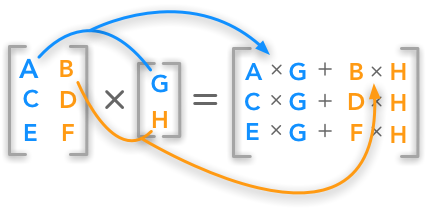

In [ ]:
yhat2=np.dot(beta,X.T)

Note that we get exactly the same result without having to manually multiply each column of X with its weight.

In [ ]:
plt.plot(X[:,0],yhat2,label='Prediction')
plt.plot(X[:,0],Y,'*',label='Data')
plt.legend()

### Evaluating a model

We can assess the performance of our model by calculating the sum of squared errors


In [ ]:
def SSE_for_model(data,yhat):

    SSE=np.sum((data-yhat)**2)
    return SSE

In [ ]:
SSE_for_model(Y,yhat2)

Another important concept is the rsquared, or variance explained

In [ ]:
def rsq_for_model(data,yhat):

    rsq = 1-(data-yhat).var(-1)/data.var(-1)
    return rsq

In [ ]:
rsq_for_model(Y,yhat2)

Here we see that our model explains 57% of the variation in Y.

## So how is this relevant to fMRI?

You may be thinking: "Thanks for patronising me by walking me through something I already knew. I want to learn how to model fMRI data 😖"

Well actually, we kind of *already have* learned how to model fMRI data. We just need to re-imagine what our variables are.

Let's imagine for a moment that X and Y are not some random numbers that I plucked out of thin air.

Let's pretend that the values in Y are ordered, and reflect the response of a single voxel on each volume of a functional scan.

In [ ]:
plt.plot(Y,'r',label='Voxel timeseries')
plt.xlabel('time (TR)')
plt.ylabel('BOLD Response (Y)')

Lets also assume that X is some predictor of this voxels response, which also unfolded over time

Let's say for instance, that the participant was asked to continuously report how much pain they felt throughout the scan on a 1-20 scale. Our predictor therefore represents the amount of pain the participant was experiencing thoughout the scan. 

We also have our constant term, which models our intercept.

In [ ]:
plt.plot(X[:,0],label='Self-reported pain')
plt.plot(X[:,1],label='Constant')
plt.xlabel('time (TR)')
plt.ylabel('Reported pain')
plt.legend()

We have already fit out model, which essentially asked the question: How much do we need to weight each column of X to get predictions that resemble Y?

So now, our first column represents self-reported pain and our second column was a constant that modeled the intercept.

If you recall, our estimated parameters indicated that we first need to multiply the self-reported pain column by around -1.75 to emulate the voxel response. Lets do this, and see how close we get to the data.

In [ ]:
plt.plot(X[:,0],label='Self-reported pain')
plt.plot((X[:,0]*beta[0]),'g',label='Self-reported pain X beta')
plt.plot(Y,'r',label='Voxel response')

plt.xlabel('time (TR)')
plt.ylabel('BOLD response')
plt.legend()

Huh? by applying our estimated weight to our predictor (green line), we actually get nowhere near emulating the voxel response. In fact, we actually do worse than when we didnt bother applying a weight at all (blue line). 

So whats going on here?

Well, this is why the intercept is important. Lets see what kind of prediction we get by multiplying the constant column of our design matrix (which models the intercept) by its weight.

In [ ]:
plt.plot(X[:,1],label='Constant')
plt.plot((X[:,1]*beta[1]),'g',label='Constant X beta')
plt.plot(Y,'r',label='Voxel response')

plt.xlabel('time (TR)')
plt.ylabel('BOLD response')
plt.legend()

Estimating the intercept has allowed us captured this vertical offset between the units of our design matrix (1-20) and the data (closer to 100).

With this vertical offset dealt with, if we additionally add the our pain predictor (scaled by its weight) to this prediction, we get a much more sensible prediction.  

In [ ]:
plt.plot(yhat2,'g',label='Full prediction')
plt.plot(Y,'r',label='Voxel response')

plt.xlabel('time (TR)')
plt.ylabel('BOLD response')
plt.legend()

Here we have modeled the response of this voxel reasionably well.

Its notable though, that the weight we applied to this predictor was negative (-1.75), so how do we interpret this?

Well, this simply means that as pain increases, the voxel response decreases.

If we re-label the axes from our previous plot, then this relationship becomes clear.

In [ ]:
plt.plot(X[:,0],yhat2,label='Linear prediction')
plt.xlabel('self-reported pain')
plt.ylabel('BOLD response')
plt.plot(X[:,0],Y,'*')
plt.legend()

We may conclude then, that this voxel responds more when we are feeling more comfortable.

### Summary

So, in conclusion, the principles we use to model fMRI data are just a form of linear regression. The only differences are:


1.   We typically have more columns (predictors) in X
2.   We typically have to do a bit of work to define these predictors.
3. We fit a model (and thus get a set of parameters) for each voxel in the brain


In the next section we will move onto our fMRI data.

# Take a break 2.

Ok, lets take a break and discuss what we have done so far.

![stop sign](https://upload.wikimedia.org/wikipedia/commons/8/81/Stop_sign.png)

# Applying a GLM to our fMRI data.



## Making regressors for our model

Ok, back to our video stimulus.

I mentioned that the video contains mutiple instances of:
1. people
2. outdoor scenes
3. text.

In principle therefore, we can use this information to:

1. *Model* BOLD responses throughout the brain as being explained by the presence of these stimuli.

2. Test *inferences* and evaluate hypotheses about the regions of the brain that are selective to these types of stimuli.

As a start, let's just record when each of these stimuli were presented.

Below I make several lists, each of which record the onset and offset of a different stimulus in the movie.


This won't be completely perfect - as natural movies often contain combinations of different stimuli - and so I have had to make a decision about what I consider the 'focal' stimulus to be

For instance, the first body appears in the movie at 26 seconds and disappears at 33 seconds.

In [ ]:
body_starts=[26, 49, 61, 72, 88, 93, 98, 104, 116, 139, 156, 164, 170]
body_ends=[33, 57, 71, 75, 90, 95, 99, 111, 136, 140, 158, 166, 190]
text_starts=[0, 21, 27, 74, 83, 91, 107, 150, 137]
text_ends=[5, 25, 31, 78, 89, 95, 109, 152, 140]
scene_starts=[20, 34, 79, 112, 146, 153, 159, 166]
scene_ends=[21, 36, 82, 116, 150, 156, 162, 170]

Lets confirm this by plotting some movie frames during this time period.

In [ ]:
jeff=videohandler('/content/data/movie/myvid.mp4')
jeff.show_video_section(body_starts[0],body_ends[0])

Let's do the same for the first occurence of text in the movie

In [ ]:
jeff.show_video_section(text_starts[0],text_ends[0])

And finally for scenes 

In [ ]:
jeff.show_video_section(scene_starts[0],scene_ends[0])

Now lets start to turn this information into an explanatory model of how we would expect a voxel to respond if it was selective to each kind of stimulus.

The simplest form of these models is a socalled ['boxcar' function](https://mathworld.wolfram.com/BoxcarFunction.html) which is a simple function that increases to 1 when a stimulus is present and 0 when it is not present. We know that fMRI responses don't look like this - but we need to start somewhere.

Lets make one of these for each category of stimulus - body, scene and text.

In [ ]:
def make_boxcar_from_times(secsbeg,secsend,full_length=205):

    event=np.zeros(full_length)      

    for c,v in enumerate(secsbeg):
        event[secsbeg[c]:secsend[c]]=1 
        
    return event

body_event=make_boxcar_from_times(body_starts,body_ends)
scene_event=make_boxcar_from_times(scene_starts,scene_ends)
text_event=make_boxcar_from_times(text_starts,text_ends)
events=np.vstack([body_event,scene_event,text_event])

from matplotlib.pyplot import figure

figure(figsize=(12, 3), dpi=80)
plt.plot(body_event,'b-',label='Bodies')
plt.plot(scene_event,'r-',label='Scenes')
plt.plot(text_event,'g-',label='Text')
plt.xlabel('time (TR)')
plt.ylabel('BOLD response')
plt.legend()

Here, we have 3 predictions about how the brain would respond if it cared about bodies, scenes and text.

Thus, we already have something resembling a design matrix, with one column for each stimulus type.

In [ ]:
plt.matshow(events.T, fignum=1, aspect='auto')

These predictors though are not yet a very biologically plausible. fMRI responses don't look like boxcars. We can improve the plausibility of the model because we know something about what the hemodynamic response function looks like.

Lets create and plot the hemodynamic response function.

In [ ]:
from scipy import signal
from nilearn.glm.first_level.hemodynamic_models import spm_hrf, spm_time_derivative, spm_dispersion_derivative

def create_hrf(hrf_params=[1.0, 1.0, 0.0],TR=1):
    """
        
    construct single or multiple HRFs        
    Parameters
    ----------
    hrf_params : TYPE, optional
    DESCRIPTION. The default is [1.0, 1.0, 0.0].
    Returns
    -------
    hrf : ndarray
    the hrf.
    
    
    Adapted from prfpy
    """
        
    hrf = np.array([np.ones_like(hrf_params[1])*hrf_params[0] *spm_hrf(tr=TR,oversampling=1,time_length=40)[...,np.newaxis],
    hrf_params[1] *spm_time_derivative(tr=TR,oversampling=1,time_length=40)[...,np.newaxis],hrf_params[2] *
    spm_dispersion_derivative(tr=TR,oversampling=1,time_length=40)[...,np.newaxis]]).sum(axis=0)
    

    return hrf.T

hrf=create_hrf()

plt.plot(hrf[0])


Now we have a model hemodynamic response function, we can now convolve it with these boxcar functions we created to get more plausible predictors.  

In [ ]:

def convolve(hrf,regressor):
    
    """
    Performs standard HRF convolution with a regressor.     
    Parameters
    ----------
    hrf : a HRF (i.e. created by create_hrf)
    Regressor: A fmri timecourse regressor
    Returns
    -------
    conv : The convolve regressor.
    """
    
    
    
    hrf_shape = np.ones(len(regressor.shape), dtype=np.int)
    hrf_shape[-1] = hrf.shape[-1]
    conv=signal.fftconvolve(regressor,hrf.reshape(hrf_shape), mode='full', axes=(-1))[..., :regressor.shape[-1]]
    return conv


In [ ]:
regs=convolve(hrf,events)
figure(figsize=(12, 3), dpi=80)

plt.plot(regs.T)
plt.xlabel('time (TR)')
plt.ylabel('BOLD response')

These now start to look like more plausible predictors. Now lets put all these together and add an intercept.

In [ ]:
import pandas as pd
nldm=pd.DataFrame(regs.T,columns=['body','scene','text'])
nldm=nldm.assign(intercept=1)
plt.matshow(nldm, fignum=1, aspect='auto')

We now have something that looks very much like the type of design matrix FSL or AFNI would create.

Thus, we have X (our design matrix), we have Y (our data), now we just need to estimate our weights. We will do this in the next section.

# Take a break 3.

Ok, lets take a break and discuss what we have done so far.

![stop sign](https://upload.wikimedia.org/wikipedia/commons/8/81/Stop_sign.png)

## Fitting the model

Ok, now we can start fitting our model. Recall the GLM equation.

\begin{align}\hat{y} = X\beta\end{align}

1. Y is our data.
2. X is the design matrix we just created.

Lets define this now.

In [ ]:
Y=np.nan_to_num(ts_data.T)
X=nldm.values

Therefore, all that is left is to solve the regression equation to estimate ${\beta}$

In [ ]:
beta = np.linalg.solve(X.T @ X, X.T @ Y)

Note that this is **exactly** the same equation/command that we used for our very simple example!

fMRI analysis is really just a *larger* case of the very simple GLM we did before. The mathematics are no different. 

In [ ]:
beta.shape

The only difference is that we have now estimated 4 ${\beta}$ (body, scene, text, intercept) for each voxel thought the brain (118584).

Let's plot the ${\beta}$ for body onto the brain.

In [ ]:
data_to_plot=cortex.Vertex(beta[0],vmin=-np.nanmax(beta[0]),vmax=np.nanmax(beta[0]),subject='hcp_999999')
flatmap=cortex.quickshow(data_to_plot)

Here we see a map of how much influence the presence of bodies had on the signal. Red regions are those for which there was an increased response to bodies. Blue are those for which there was a decreased response. White are those regions for which there was no influence on the response. 

## Looking at predictions

To make sense of these beta-weights, let's look at some predictions. Note again, that we can retrieve these in exactly the same way as our simple example, via the dot product of X and the betas.

In [ ]:
yhat=np.dot(X,beta)

This gives us a set of predictions, which is the same shape as our data, since we get a prediction for each one of our voxels.

In [ ]:
yhat.shape

Lets take a look at the data and the prediction for the voxel with the highest beta weight for bodies. In other words, the voxel for which bodies were estimated to have the largest influence on the its response.

In [ ]:
plt.plot(yhat[:,np.nanargmax(beta[0])],label='Model prediction')
plt.plot(Y[:,np.nanargmax(beta[0])],label='Data')
plt.xlabel('time (TR)')
plt.ylabel('BOLD response')
plt.legend()

This is actually a rather good prediction.

This prediction is of couse partly achieved by multiplying the body regressor by its beta weight.

In [ ]:
plt.plot(X[:,0],'black',label='body predictor')
plt.plot(X[:,0]*beta[0,np.nanargmax(beta[0])],'g',label='body predictor X weight')
plt.ylim([-0.5, 3])
plt.xlabel('time (TR)')
plt.ylabel('BOLD response')
plt.legend()

Notice how much this predictor has been 'stretched' by multiplying by its weight.

By contrast, a small negative weight was applied to scenes for this voxel, indicating the presence of scenes has a negative influence on the signal.

In [ ]:
plt.plot(X[:,1],'black',label='scene predictor')
plt.plot(X[:,1]*beta[1,np.nanargmax(beta[0])],label='Scene X weight')
plt.ylim([-0.5, 3])
plt.xlabel('time (TR)')
plt.ylabel('BOLD response')
plt.legend()

The same is true for text

In [ ]:
plt.plot(X[:,2],'black',label='text predictor')
plt.plot(X[:,2]*beta[1,np.nanargmax(beta[0])],'orange',label='text X weight')
plt.ylim([-0.5, 3])
plt.xlabel('time (TR)')
plt.ylabel('BOLD response')
plt.legend()

Let's take a look at all of these together.

We can see that the presence of bodies had by far the most infuence on the signal, in the positive direction, whereas the presence of other two stimuli led to negative defelections in the signal.

In [ ]:
plt.plot(X[:,1]*beta[1,np.nanargmax(beta[0])],label='scene X weight')
plt.plot(X[:,2]*beta[2,np.nanargmax(beta[0])],label='text X weight')
plt.plot(X[:,0]*beta[0,np.nanargmax(beta[0])],label='body X weight')
plt.xlabel('time (TR)')
plt.ylabel('BOLD response')
plt.legend()

The full prediction is just the linear combination (sum) of these seperate elements.

We already got the predictions via dot product, but lets just prove this now by manually adding everything together.

In [ ]:
plt.plot((X[:,0]*beta[0,np.nanargmax(beta[0])])+(X[:,1]*beta[1,np.nanargmax(beta[0])])+(X[:,2]*beta[2,np.nanargmax(beta[0])])+(X[:,3]*beta[3,np.nanargmax(beta[0])]),label='Model prediction')
plt.xlabel('time (TR)')
plt.ylabel('BOLD response')
plt.plot(Y[:,np.nanargmax(beta[0])],label='Data')
plt.legend()

## What now?

Well now we might begin to suspect that this voxel is more responsive to faces than it is to scenes.

The raw beta-weights might suggest this, but to strengthen this conviction we actually want to perform some kind of inferential test.

# Take a break 4.

Ok, lets take a break and discuss what we have done so far.

![stop sign](https://upload.wikimedia.org/wikipedia/commons/8/81/Stop_sign.png)

# The t test

A t-test is an inferential statistic used to determine if there is a significant difference between two parameters. It's form is as follows: 

\begin{align}
t_{\hat{\beta}} = \frac{\hat{\beta}}{\mathrm{SE}_{\hat{\beta}}}
\end{align}



A useful way of thinking about t-value is an effect ($\hat{\beta}$) 
 divided by your uncertainty or confidence in the effect
($\mathrm{SE}_{\hat{\beta}}$). In a way, you can think of t-values as “uncertainty-normalized” effects.

Thus, larger values of the effect (top half of the equation) will increase the t value and smaller values of the uncertainty will decrease the t value (bottom half of the equation).

Hence, we get the highest t values if we have larger effects and smaller uncertainties.

### The numerator (top half) of the t value

One useful way of defining an 'effect' ($\hat{\beta}$) is by some linear combination of the beta weights estimated by our model, which we define as a *contrast*.

Lets suppose we wanted test the following null hypothesis:

**"There is no difference in the voxel's response to bodies and scenes"**

In terms of the parameters fit by our model, this could be defined as ${\beta}$(body)-${\beta}$(scene)=0

In other words, "the difference between the body and scene ${\beta}$ estimated by our model is zero"

We could test this hypothesis with the following contrast vector [1,-1,0,0]

In [ ]:
contrast1=np.array([1,-1,0,0])

Think back to the concept of a dot product/ matrix multiplication.

If we take the dot product of the betas estimated by our model and this vector, this implies multiplying our body beta weight (first column of our beta matrix) by 1 and our scene beta weight (second column of our beta matrix) by -1 and taking the sum.

Since the other columns will be multiplied by zero - they have no influence on the final result.

In other words, this just gives us *the difference between the body and scene beta weight*.

Here I plot the result of a dot product and a simple subtraction of these columns to confirm that they lead to the same result.

In [ ]:
plt.plot(np.dot(contrast1,beta),beta[0]-beta[1])
plt.xlabel('Dot product')
plt.ylabel('Body-scene beta')

So we actually already have the numerator for *t*, or our 'effect' ($\hat{\beta}$). This is just the difference between body and scene beta weights.

Lets plot this onto the brain. 

In [ ]:
t_numerator=np.dot(contrast1,beta)

data_to_plot=cortex.Vertex(t_numerator,vmin=-np.nanmax(t_numerator),vmax=np.nanmax(t_numerator),subject='hcp_999999')
flatmap=cortex.quickshow(data_to_plot)

Thus here positive values (red) indicate regions where bodies have had a more positive influence on the signal than scenes.

However, to obtain the inferential power of the t statistic (i.e. our ability to test the hypothesis) we need to normalise by the uncertainty ($\mathrm{SE}_{\hat{\beta}}$).

### The denominator of the t value.

So, what drives (statistical) uncertainty about “effects”? To find out, let’s dissect the uncertainty term ($\mathrm{SE}_{\hat{\beta}}$) a little more. The standard error of a parameter can interpreted conceptually as the “unexplained variance of the model” (or noise) multiplied with the “design variance” (or: the variance of the parameter due to the design). We wont worry about this desgin variance component for now - we can revisit this another time. All we need to know is that the denominator of the t value reflects the uncertainty of our estimates.

\begin{align}
\mathbf{SE}_{\hat{\beta}} = \sqrt{\mathrm{noise} \cdot \mathrm{design\ variance}}
\end{align}

In fact, the 'noise' term involves a concept we have already discussed - the sum the squared residuals divided by the model's degrees of freedom (DF).

The degrees of freedom in this case is the number of timepoints in the dataset (205 in our case) minus the number of columns in our design matrix (4). People usually use the $\hat{\sigma}^{2}$ symbol for this noise term:

\begin{align}
\mathrm{noise} = \hat{\sigma}^{2} = \frac{\sum_{i=1}^{N}(\hat{y_{i}} - y_{i})^2}{\mathrm{df}} 
\end{align}

Lets calculate the noise term and plot this onto the brain

In [ ]:
  # t denominator
import numpy.linalg as npl
n = Y.shape[0] # Timepoints
df_error = n - npl.matrix_rank(X) # Timepoints- precictors.
E = Y - yhat # Error
sigma_2 = np.sum(E ** 2, axis=0) / df_error # Sum of squared errors

In [ ]:
data_to_plot=cortex.Vertex(sigma_2,vmin=0,vmax=np.nanmax(sigma_2),subject='hcp_999999',cmap='plasma')
flatmap=cortex.quickshow(data_to_plot)

Here we see brighter regions reflecting those regions with greater unexplained variance. In other words, these are the regions where we are more *uncertain* about our parameter estimates.

Now, if we add the design variance (again don't worry about this) to the noise we get the denominator of our t test.

In [ ]:
design_variance= contrast1.dot(npl.pinv(X.T.dot(X))).dot(contrast1) # Design variance
t_denominator=np.sqrt(sigma_2 * design_variance) 

Now then, we have our numerator
($\hat{\beta}$) 
and our denominator
($\mathrm{SE}_{\hat{\beta}}$)

### Putting it together : the t statistic

Now all there is left to do is divide our numerator by our denominator (generating our *t* statistic) and plot it.

In [ ]:
tstat=t_numerator/t_denominator
data_to_plot=cortex.Vertex(tstat,vmin=-np.nanmax(tstat),vmax=np.nanmax(tstat),subject='hcp_999999')
flatmap=cortex.quickshow(data_to_plot)

Here larger t statistics (darker blue and red) provide more evidence against the null hypothesis that the response to bodies is the same as the response to scenes. White regions are more consistent with the null.

### P values

Ok, now we have our t statistics, the next step is to calculate the chances of obtaining our statistics *if the null hyptothesis were true*. Or in other words, our *p* value. We then want to focus on those voxels for which we can reject the null.

Usually this involves those that have a p value <.05.

We can obatin these p values from the t value and degrees of freedom.

In [ ]:
import scipy.stats as stats
t_dist = stats.t(df_error)
p = 1 - t_dist.cdf(tstat)

Now lets again plot thes t values onto the brain, but show only those regions with a p value <.05

In [ ]:
data_to_plot=cortex.Vertex2D(tstat,p<.05,vmin=2,vmax=5,vmin2=0,vmax2=1,subject='hcp_999999',cmap='plasma_alpha')
flatmap=cortex.quickshow(data_to_plot,with_curvature=True)

We can interpret the visible regions of the brain as being those with significantly larger responses to bodies than scenes. In other words, these are regions for which we can reject the null hypothesis that ($\hat{\beta}$) = 0

We could be more conservative here and apply a [bonferroni](https://en.wikipedia.org/wiki/Bonferroni_correction) correction.

In other words, our alpha level (p<.05) admits a < 5% chance that the data could have been obtained if the null hypothesis is true. This is ok if we are just performing one test.

However, we are performing a lot of independent test here (we have ~118,000 voxels in the brain), so we could expect a large portion of our tests (118,000 x .05) = *5900* to be *false positives*. In other words, our *type 1 error rate* might be reaching an unacceptable level. 

We can correct for this type 1 error rate by dividing our alpha level (.05) by the number of voxels in our analysis (~118,000). Thus, we would have to reach the much smaller p value (0.00024) to reject the null.

Lets plot the voxels that are under this much lower p value. 

In [ ]:
data_to_plot=cortex.Vertex2D(tstat,p<(.05/Y.shape[0]),vmin=2,vmax=5,vmin2=0,vmax2=1,subject='hcp_999999',cmap='plasma_alpha')
flatmap=cortex.quickshow(data_to_plot,with_curvature=True)

We see that many of these voxels survive the correction, however our population of significant voxels has very much shrunk.

## Another, more complex contrast. 

Finally, lets repeat this entire process, but instead testing the null hypothesis:

**"There is no difference in the voxel's response to text versus bodies and scenes"**

Here, we are explicitly testing text (the third column of our design matrix) against bodies *and* scenes. Hence, we need a different contrast vector.

In [ ]:
contrast2=np.array([-0.5,-0.5,1,0])

Note that comparisons between conditions can take any form as long as the contrast vector sums to zero. Hence, when comparing one condition to two others like this we need to make sure these elements sum to 0.

In [ ]:
np.sum(contrast2)

Ok, now rather than breaking the formula down into its various parts, lets just estimate the t value and p for this contrast in one fell swoop and generate the same plot as before. 

In [ ]:
def tvalue(c,X,Y):
  # t numerator
  beta=np.linalg.solve(X.T @ X, X.T @ Y) # betas
  yhat=np.dot(X,beta) # predictions

  top_of_t = c.dot(beta) # Numerator

  # t denominator
  n = Y.shape[0] # Timepoints
  df_error = n - npl.matrix_rank(X) # Timepoints- precictors.
  E = Y - yhat # Error
  sigma_2 = np.sum(E ** 2, axis=0) / df_error # Sum of squared errors
  c_b_cov = c.dot(npl.pinv(X.T.dot(X))).dot(c) # Design variance

  bot_of_t=np.sqrt(sigma_2 * c_b_cov)  # denominator

  # t
  t = top_of_t / bot_of_t
  t_dist = stats.t(df_error)
  p = 1 - t_dist.cdf(t)

  return t,p

text_t=tvalue(contrast2,X,Y)
data_to_plot=cortex.Vertex2D(text_t[0],text_t[1]<.05/Y.shape[0],vmin=2,vmax=5,vmin2=0,vmax2=1,subject='hcp_999999',cmap='plasma_alpha')
flatmap=cortex.quickshow(data_to_plot,with_curvature=True)


Great. Here we reveal regions of the brain whose response is significantly larger to text than it is to bodies or scenes.



# Summary
## Great work!!!

We did an fMRI analysis from scratch! 👏

The good news is that we never have to do all of this from scratch in the way that we have done here(unless you feel the need to punish yourself in the same way that I do...) 😀

Software like FSL handles all of this for us, from the creation of the design matrix, specifying the model and contrasts and generating the statistical maps - this is all highly automated and just a question of clicking buttons.

However, FSL hides a ot of things under the hood - and so it is good to try and spell these things out.

It can be quite straighforward to run a very complex model in FSL - but only have a superficial understanding of how it happened.

The good news is that if you more or less followed what we did here, then using FSL should be an absolute cinch. In fact, you will now be in a much better position to understand exactly what FSL and FEAT does to produce statistical parametric maps. 

---

### Some key points*

1. fMRI analysis is the same as a simple linear regression, just operating on a larger scale. We use exactly the same formulae and estimate the parameters in exactly the same way.
2. We can make inferences and test hypotheses about brain responses using t statistics.
3. A t statistic can be thought of as the size of an effect (expressed as a linear combination of our estimated parameters) divided by the uncertainty in our estimate (which takes into account the unexplained variance of our model and design variance).





# Things to think about

1. How might we improve our model? What other predictors could we include to explain the variance ?
2. What contrast vector would we use to test the null hypothesis that the beta weight for bodies is == 0 ?
3. We used a bonferroni correction to adjust our alpha level. Why might this not be a good idea?